In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.2.2+cpu  Device: cpu


In [4]:
from torchinfo import summary

In [5]:
from torch.utils.data import Dataset
# pentru citire de fisier cvs, verificare cai etc:
import pandas as pd
import os
from typing import Tuple
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        Initializeaza setul de date, folosind o cale catre fisier csv si indicatie despre clasa pozitiva si negativa
        :param path_csv: cale catre fisier CSV care contine date de train sau test
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte 
        super().__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indica spre un fisier'
        self.path_csv = path_csv
        
        _all_digits = pd.read_csv(path_csv, header=None).values
        # valorile de intrare in x, etichetele in y 
        _y = _all_digits[:, 0]
        _x = _all_digits[:, 1:]
        # valorile 0..255 din setul de intrare _x sunt scalate la 0..1
        _x = _x / 255

        self.x = _x
        self.y = _y
        
        # convertim din numpy array in torch tensors:
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)
        
    def __len__(self):
        """
        Returneaza lungimea setului de date curent
        :return: lungimea setului de date
        """
        return len(self.y)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returneaza perechea (intrare, eticheta_asociata) de pe pozitia :param index:
        :param index: pozitia de pe care se returneaza vectorul si clasa lui
        :return: pereche: vector de intarre de 784 de elemente, eticheta clasa 0 sau 1
        """
        return self.x[index, :], self.y[index]

train_ds = MNISTDataset('./data/mnist_train.csv')
test_ds = MNISTDataset('./data/mnist_test.csv')

assert len(train_ds) == 60000
assert len(test_ds) == 10000

In [6]:
from torch.utils.data import DataLoader

In [7]:
batch_size = 32 # in functie de memoria disponibila pe GPU
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# pentru primul minibatch tiparim 'shape'
# datele de intrare ar tb sa fie un tensor de forma (batch_size x 784)
# etichetele ar trebui sa fie un tensor de forma batch_size
for data, label in train_loader:
    print(data.shape, label.shape)
    # print(data, label)
    break
    
# restul de minibatchuri arata la fel, eventual exceptand ultimul minibatch

torch.Size([32, 784]) torch.Size([32])


In [8]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784, number_of_classes: int = 10):
        """
        Initializarea unui obiect de tip LogisticRegression
        :param input_size: dimensiunea unui vector de intrare. De ex, pt MINST este 784
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte
        super().__init__()
        self.input_size = input_size
        # initializam ponderile ca o matrice de input_size x 1 elemente aleatoare
        # matrice = operator liniar
        self.fully_connected = nn.Linear(input_size, number_of_classes, bias=True)

    def forward(self, x):
        # x este un minibatch de exemplu de forma 32x784 (ultimul minibatch poate avea mai putin de 32 de tensori)

        # se propaga dinspre stratul de intrare spre primul strat ascuns
        # aplicarea unei functii liniare este echivalenta cu inmulttirea unei matrice cu intrarea curenta
        x = self.fully_connected(x)
        
        # se aplica functia logistic sigmoid pentru a obtine probabilitatea conditionata
        # x = torch.sigmoid(x)
        
        return x

In [9]:
model = MultinomialLogisticRegression(input_size=784, number_of_classes = 10)

print(model)

summary(model)

print(f'device={device}')

model.to(device)

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)
device=cpu


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

In [10]:
for x, y in train_loader:
    # datele si modelul trebuie sa fie pe acelasi device, altfel calculele nu se pot efectua
    x, y = x.to(device), y.to(device)
    
    # produce predictia, tensor plin cu probabilitati
    y_hat = model(x).squeeze()
    print(f'Predictii (probabilitati): {y_hat}')
    
    # daca probabilitatea conditionata este >= 0.5, atunci modelul prezice clasa pozitiva (1), altfel 0 
    clase = torch.argmax(y_hat, axis = 1)
    # clase e un vector de booleni; True = 1, False = 0
    print('Cate clase au fost prezise corect: ', (clase == y).sum())
    
    # ne oprim dupa primul minibatch aici, e doar pentru a vedea cum arata predictiile facute de model
    break 

Predictii (probabilitati): tensor([[-2.6304e-02, -8.0826e-02, -3.1255e-02,  1.7739e-01,  6.9390e-02,
         -5.9107e-02,  2.4816e-01, -1.5619e-01, -1.7174e-01, -1.8592e-01],
        [-2.1999e-01,  4.6788e-02, -1.4614e-01, -3.3897e-02,  1.9148e-01,
          4.8601e-03, -1.6312e-01,  2.0296e-01,  1.1574e-01,  3.2123e-01],
        [-1.1955e-01, -2.2378e-01,  1.8845e-01,  1.6288e-01, -5.0845e-02,
         -7.7294e-02, -1.0566e-01, -8.1791e-02, -2.2311e-01, -3.6653e-02],
        [-3.2803e-02, -3.5221e-01,  1.9286e-01, -5.5283e-02, -4.7003e-02,
          5.6073e-02, -5.7342e-01,  1.8341e-01,  3.9894e-01, -3.0800e-01],
        [-7.9168e-02, -1.3262e-01, -4.6881e-02,  1.8725e-01, -2.2541e-02,
         -1.8396e-01,  8.8251e-02,  5.3027e-03, -5.5390e-03,  1.9313e-01],
        [ 7.7580e-02, -1.8621e-01,  4.5774e-02, -3.2072e-02, -8.9460e-02,
         -2.4540e-01, -1.9260e-01, -1.3765e-02, -1.0083e-01, -2.0277e-01],
        [-2.3834e-01, -2.7072e-01,  3.1256e-01,  2.5648e-01, -8.9184e-02,
     

In [11]:
# dezactivam urmarirea automata a tensorilor pentru care se pot calcula gradienti:
# gradientii sunt folositidoar la antrenare, nu si la testare
@torch.no_grad()
def test(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Testeaza modelul pe datele furnizate de :param loader:
    :param model: model de regresie logistica binara
    :param loader: un dataloader care furnizeaza datele din setul peset care se testeaza
    :param device: pe ce device se afla modelul (cpu, gpu, tpu etc)
    :return: acuratetea de predictie
    """
    # initializare valori pt statistica
    correctly_classified = 0
    total_items = 0
    # cand se face testarea, modelul nu mai invata. El e trecut explicit in mod de testare
    model.eval()
    for x, y in loader:
        # trecem datele din setul de testare pe acelasi device ca si modelul
        x, y = x.to(device), y.to(device)
        
        # modelul prezice probabilitatile conditionate pentru minibatchul curent
        y_hat = model(x).squeeze()
        
        # predictia e clasa pozitiva daca probabilitatea e >=0.5, altfel clasa negativa
        predicted_class = torch.argmax(y_hat, axis = 1)
        
        correctly_classified += torch.sum(predicted_class == y)
        total_items += len(x)
    accuracy = correctly_classified / total_items
    return accuracy.cpu().detach().item()

In [12]:
acc = test(model, test_loader, device)
print(f'Acuratetea modelului neantrenat: {acc * 100}%')

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-3)

# definim functia de eroare, binary cross entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

# numarul de epoci
epochs = 30

Acuratetea modelului neantrenat: 11.760000139474869%


In [13]:
losses = []
accuracies = []
for epoch in range(epochs):
    # modelul trebuie trecut in modul train inainte de a se face instruirea lui
    # trecerea lui pe modul eval apare la apelul metodei de test()
    model.train()
    epoch_loss = 0
    total_items = 0
    for x, y in train_loader:
        # trecem datele din setul de antrenare pe acelasi device ca si modelul
        x, y = x.to(device), y.to(device)
        
        # stergem gradientii calculati anterior, altfel se face acumulare e gradienti - nu e de interes pt acest model
        model.zero_grad()
        
        # modelul prezice probabilitatile conditionate pentru minibatchul curent
        y_hat = torch.squeeze(model(x))
        
        # se calculeaza functia de eroare pe minibatchul curent
        loss = loss_fn(y_hat, y.long())
        # loss-ul calculat este media valorii de eroare peste minibatchul curent; 
        # inmultim media cu numarul de valori din minibatch pentru a determina valoarea cumulata 
        # a erorii pe minibatch
        epoch_loss += loss.item() * len(x)
        # actualizam numarul total de valori peset care s-a facut invatarea
        total_items += len(x)
        
        # cerem calcul de gradienti
        loss.backward()
        
        # optimizatorul aplica gradientii pe ponderi = invatare
        optimizer.step()
    
    epoch_loss /= total_items
    losses.append(epoch_loss)
    # afisam statistici
    print(f'Epoca: {epoch+1}/{epochs}: loss = {epoch_loss:.7f}')
    acc_test = test(model, test_loader, device)
    accuracies.append(acc_test)
    print(f'Epoca: {epoch + 1}/{epochs}: acuratete pe setul de testare = {acc_test * 100:.4f}%\n')

Epoca: 1/30: loss = 0.4185592
Epoca: 1/30: acuratete pe setul de testare = 91.0300%

Epoca: 2/30: loss = 0.3236097
Epoca: 2/30: acuratete pe setul de testare = 91.5300%

Epoca: 3/30: loss = 0.3099811
Epoca: 3/30: acuratete pe setul de testare = 91.9500%

Epoca: 4/30: loss = 0.3041514
Epoca: 4/30: acuratete pe setul de testare = 92.0100%

Epoca: 5/30: loss = 0.3008507
Epoca: 5/30: acuratete pe setul de testare = 91.8500%

Epoca: 6/30: loss = 0.2988359
Epoca: 6/30: acuratete pe setul de testare = 91.9500%

Epoca: 7/30: loss = 0.2973001
Epoca: 7/30: acuratete pe setul de testare = 92.1500%

Epoca: 8/30: loss = 0.2964529
Epoca: 8/30: acuratete pe setul de testare = 92.0600%

Epoca: 9/30: loss = 0.2954089
Epoca: 9/30: acuratete pe setul de testare = 92.0600%

Epoca: 10/30: loss = 0.2954034
Epoca: 10/30: acuratete pe setul de testare = 91.9800%

Epoca: 11/30: loss = 0.2950997
Epoca: 11/30: acuratete pe setul de testare = 91.9200%

Epoca: 12/30: loss = 0.2946222
Epoca: 12/30: acuratete pe set

In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

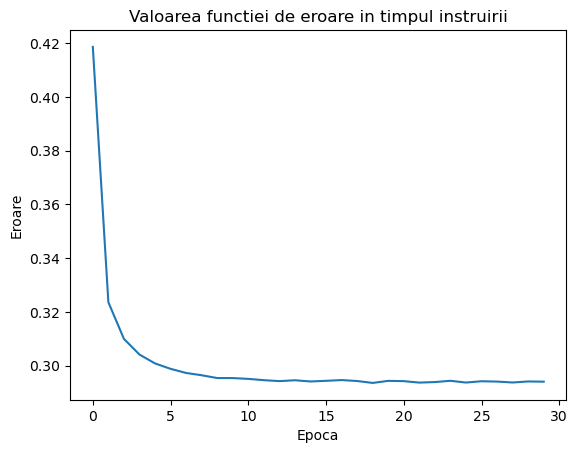

In [15]:
plt.plot(losses)
plt.xlabel('Epoca')
plt.ylabel('Eroare')
plt.title(f'Valoarea functiei de eroare in timpul instruirii')
plt.show()

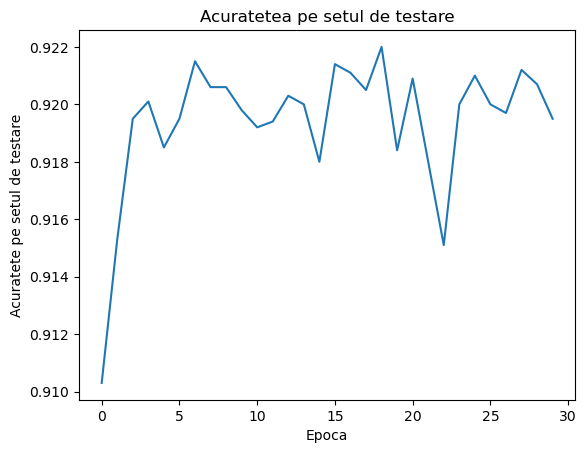

In [16]:
plt.plot(accuracies)
plt.xlabel('Epoca')
plt.ylabel('Acuratete pe setul de testare')
plt.title(f'Acuratetea pe setul de testare')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix


model.eval()
all_labels = []
all_predictions = []

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    predicted_class = torch.argmax(y_hat,dim=1) 

    all_labels.extend(y.cpu().numpy())
    all_predictions.extend(predicted_class.cpu().numpy())
cm=confusion_matrix(all_labels,all_predictions)

print(cm)

[[ 962    0    1    1    0    3    8    2    3    0]
 [   0 1106    2    2    1    2    4    2   16    0]
 [   6    6  913   14   15    4   13   13   43    5]
 [   3    0   23  907    0   29    2   15   25    6]
 [   1    1    2    1  939    0   11    2   10   15]
 [  10    1    3   34   13  760   16   11   39    5]
 [  13    3    4    1   13   10  907    2    5    0]
 [   1    7   24    6   12    0    0  955    3   20]
 [   6    4    6   13   11   21   11   11  886    5]
 [   9    5    2    9   72    5    0   34   13  860]]
